In [1]:
#essential imports
%matplotlib inline 
from __future__ import division

In [2]:
#Utilities imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#Specific usage imports
from openfisca_core import rates
from openfisca_core.tools import get_trace_tool_link
import openfisca_france

Initialize the tax and benefit system of France

In [4]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

Create a scenario

In [5]:
ax_variable_max = 40000
count = 1000
def make_single_with_child_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count):
    enfant = [dict(
        age = 12,
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation_logement = 4,
            depcom = 13012,
            ),
        )
    return scenario

def make_couple_with_child_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count):
    enfant = [dict(
        age = 12,
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = 1
            ),
        parent2 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = 1
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation_logement = 4,
            depcom = 13012,
            ),
        )
    return scenario


In [6]:
sim_dict_2016 = dict(); sim_dict_2016[0] = dict(); sim_dict_2016[1] = dict()
for couple in [True, False]:
    if couple == True:
        sim_dict_2016[0]
        for children in range(0,4):
            simulation = make_single_with_child_scenario(nombre_enfants= children,
                                                         year = 2016).new_simulation()
            sim_dict_2016[0][children] = simulation
    if couple == False:
        sim_dict_2016[1]
        for children in range(0,4):
            simulation = make_couple_with_child_scenario(nombre_enfants= children,
                                                         year = 2016).new_simulation()
            sim_dict_2016[1][children] = simulation
            
sim_dict_2015 = dict(); sim_dict_2015[0] = dict(); sim_dict_2015[1] = dict()
for couple in [True, False]:
    if couple == True:
        sim_dict_2015[0]
        for children in range(0,4):
            simulation = make_single_with_child_scenario(nombre_enfants= children,
                                                         year = 2015).new_simulation()
            sim_dict_2015[0][children] = simulation
    if couple == False:
        sim_dict_2015[1]
        for children in range(0,4):
            simulation = make_couple_with_child_scenario(nombre_enfants= children,
                                                         year = 2015).new_simulation()
            sim_dict_2015[1][children] = simulation

## 2016

In [7]:
simulation = sim_dict_2015[0][3]
simulation.calculate("aides_logement")[0]/12 #pourquoi si bas !

106.45235188802083

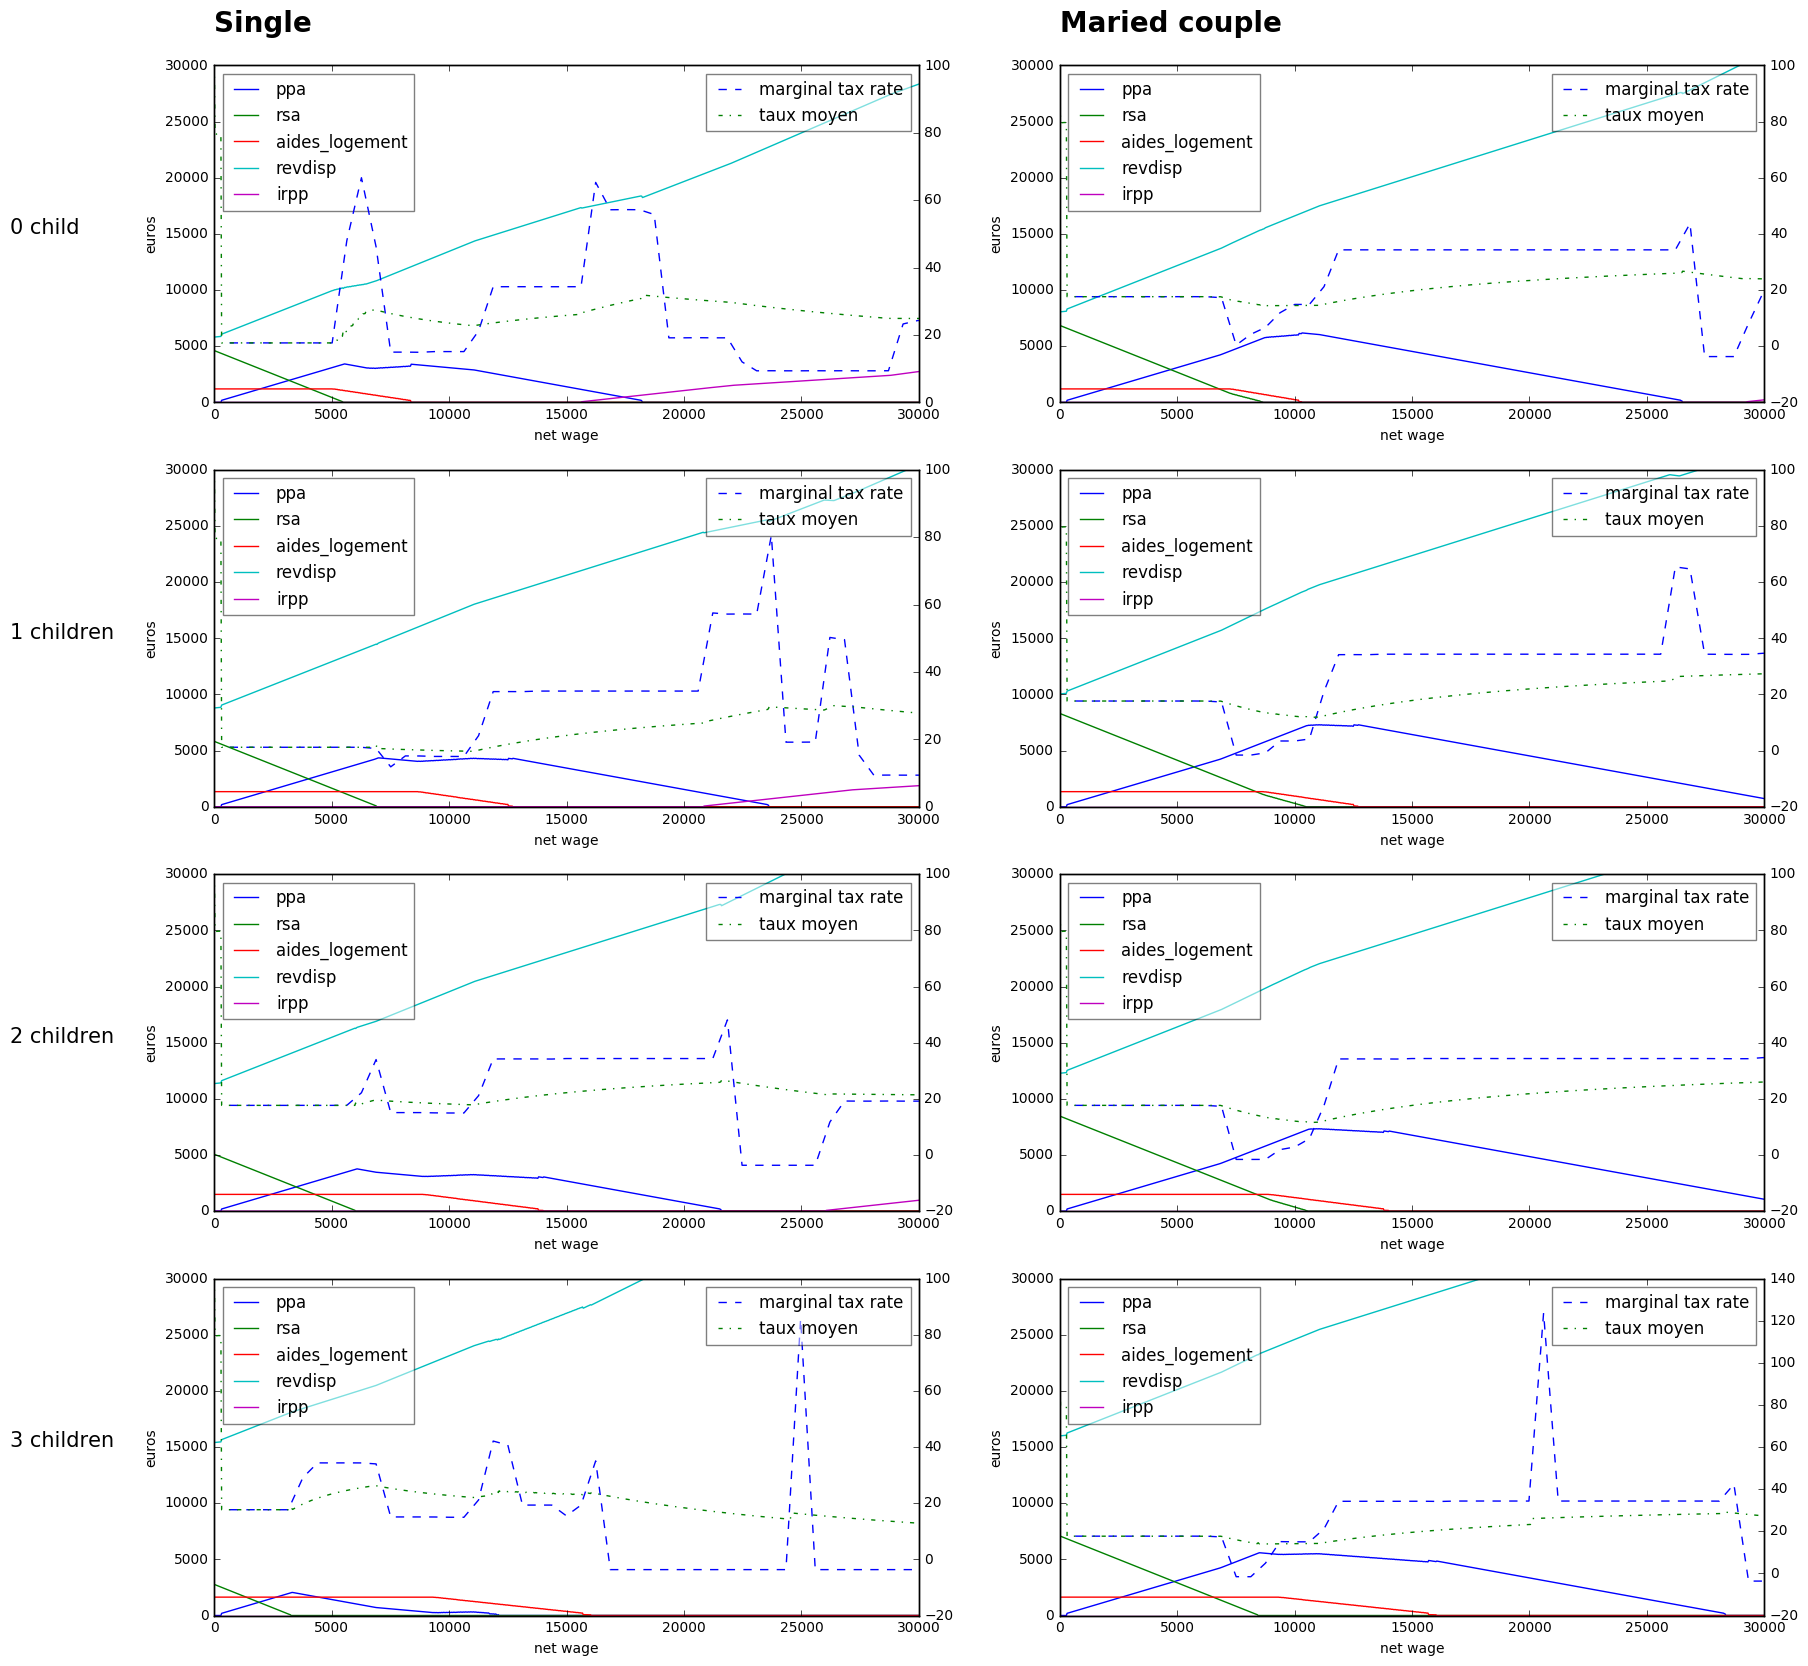

In [8]:
fig, ax = plt.subplots(4,2,figsize=(20, 20))

for col in range(2):
    for raw in range(4):
        simulation = sim_dict_2016[col][raw]
        for var in ["ppa","rsa","aides_logement","revdisp", "irpp"]:
            ax[raw,col].plot(
                     simulation.calculate_add("salaire_net")[::raw+col+1],
                     np.abs(simulation.calculate_add(var)), label = var
                    )
        
        
        # Tax rate
         ## Marginal Tax rate
        ax2 = ax[raw,col].twinx()

        smooth = 20 # need to be >= 2
        ax2.plot(simulation.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth],
                (
                rates.marginal_rate(simulation.calculate_add("revdisp")[::smooth],
                simulation.calculate("salaire_net")[::raw+1+col][::smooth])
                )*100,
                '--',
                label = "marginal tax rate",
            )

        ax2.plot(simulation.calculate_add("salaire_net")[::raw+1+col],
                (
                (rates.average_rate(simulation.calculate_add("revdisp")-simulation.calculate_add("revdisp")[0],
                simulation.calculate("salaire_net")[::raw+1+col]))
                )*100,
                 "g-.",
                 label = "taux moyen",
            )
        legend = ax2.legend(loc = 1); legend.get_frame().set_alpha(0.5)


  
        ax[raw,col].set_xlim(0,30000)
        ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 2); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros'); ax[raw,col].set_xlabel('net wage');
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'child'*(raw==0)+'children'*(raw>0)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Single"*(col==0)+u"Maried couple"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')

## 2015

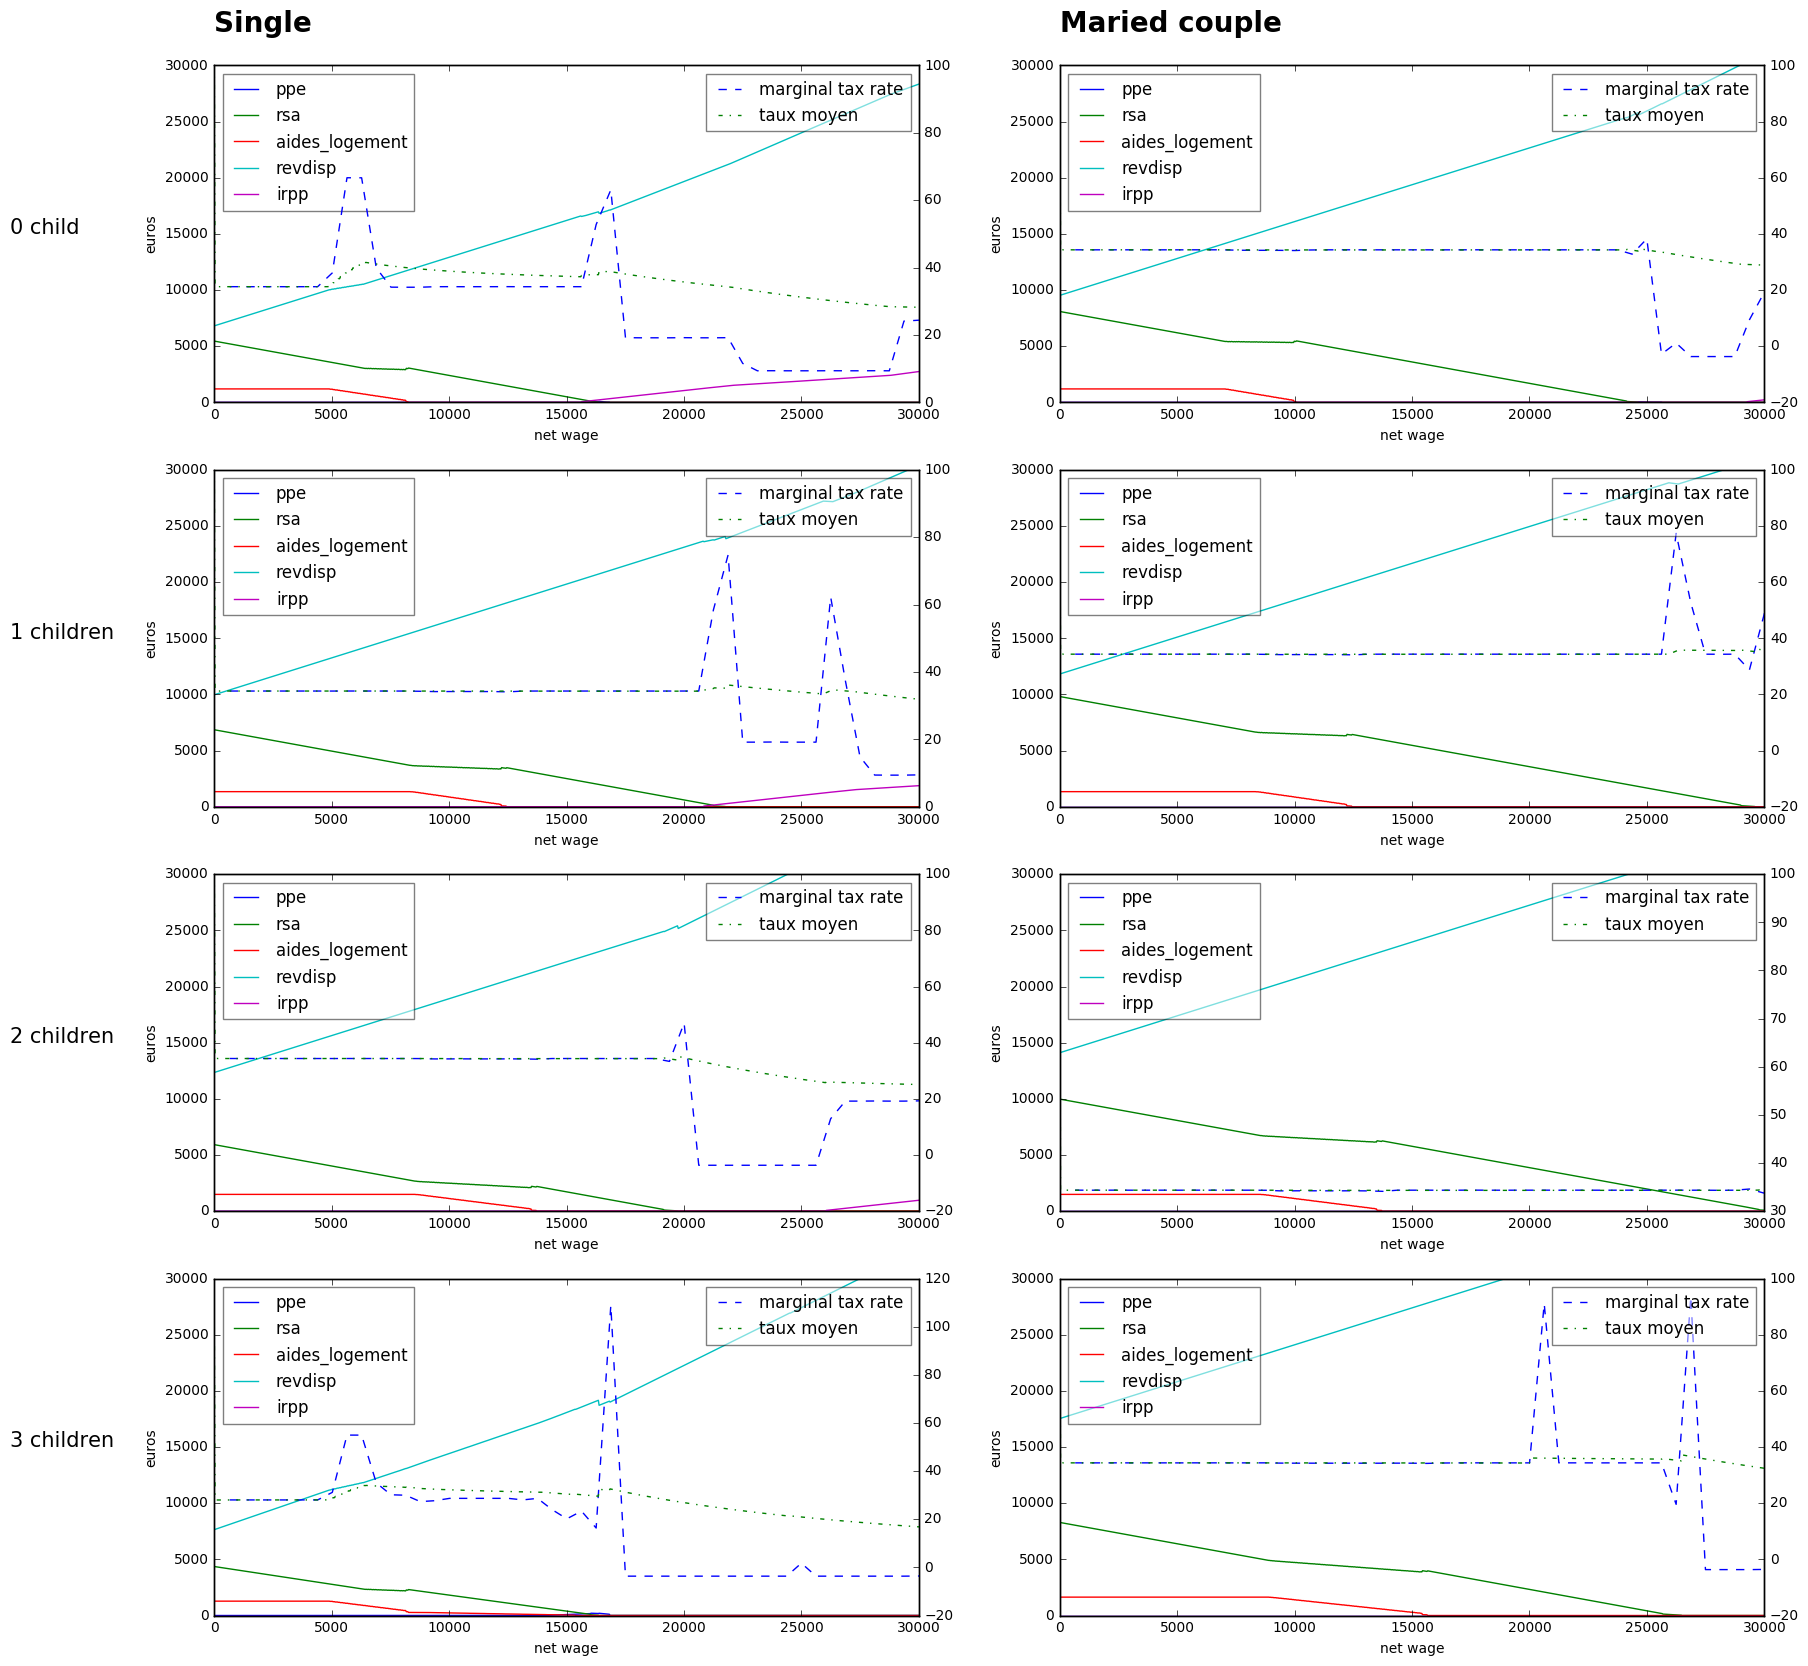

In [9]:
fig, ax = plt.subplots(4,2,figsize=(20, 20))

for col in range(2):
    for raw in range(4):
        simulation = sim_dict_2015[col][raw]
        for var in ["ppe","rsa","aides_logement","revdisp", "irpp"]:
            ax[raw,col].plot(
                     simulation.calculate_add("salaire_net")[::raw+col+1],
                     np.abs(simulation.calculate_add(var)), label = var
                    )
            
        # Tax rate
         ## Marginal Tax rate
        ax2 = ax[raw,col].twinx()

        smooth = 20 # need to be >= 2
        ax2.plot(simulation.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth],
                (
                rates.marginal_rate(simulation.calculate_add("revdisp")[::smooth],
                simulation.calculate("salaire_net")[::raw+1+col][::smooth])
                )*100,
                '--',
                label = "marginal tax rate",
            )
         ## Average Tax rate
        ax2.plot(simulation.calculate_add("salaire_net")[::raw+1+col],
                (
                (rates.average_rate(simulation.calculate_add("revdisp")-simulation.calculate_add("revdisp")[0],
                simulation.calculate("salaire_net")[::raw+1+col]))
                )*100,
                 "g-.",
                 label = "taux moyen",
            )
        legend = ax2.legend(loc = 1); legend.get_frame().set_alpha(0.5)


  
        ax[raw,col].set_xlim(0,30000)
        ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 2); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros'); ax[raw,col].set_xlabel('net wage');
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'child'*(raw==0)+'children'*(raw>0)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Single"*(col==0)+u"Maried couple"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')

## 2015 vs. 2016

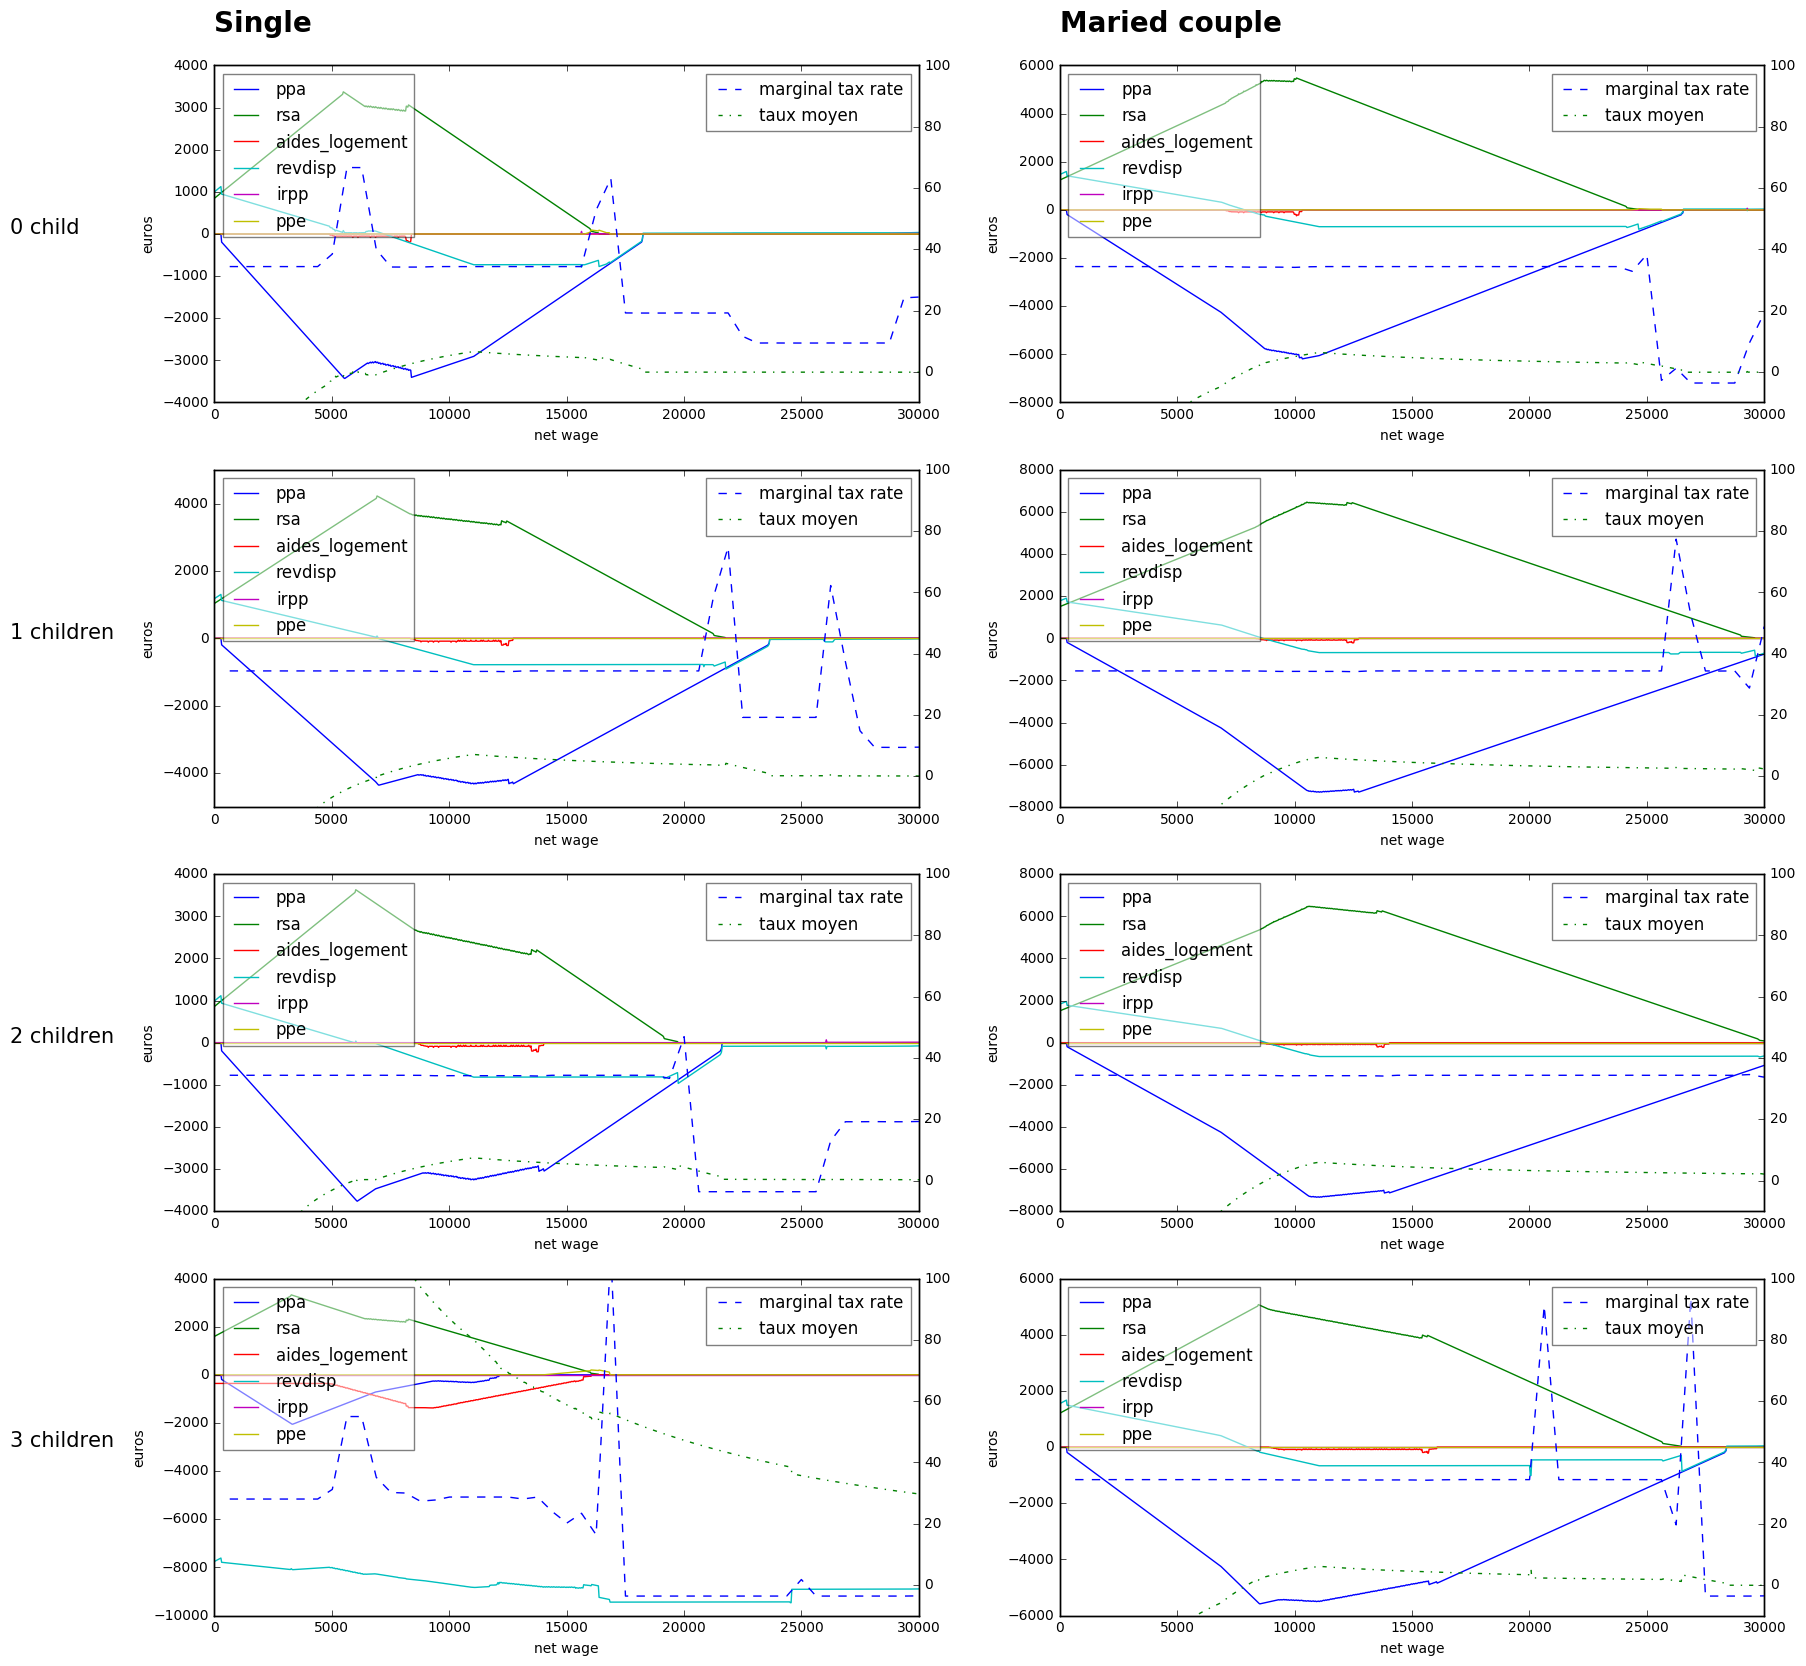

In [10]:
fig, ax = plt.subplots(4,2,figsize=(20, 20))

for col in range(2):
    for raw in range(4):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        for var in ["ppa","rsa","aides_logement","revdisp", "irpp","ppe"]:
            ax[raw,col].plot(
                     simulation_2015.calculate_add("salaire_net")[::raw+col+1],
                     np.abs(simulation_2015.calculate_add(var)) -  np.abs(simulation_2016.calculate_add(var)),
                label = var
                    )
    
        # Tax rate
         ## Marginal Tax rate
        ax2 = ax[raw,col].twinx()
        smooth = 20 # need to be >= 2
        ax2.plot(simulation_2015.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth],
                (
                rates.marginal_rate(simulation_2015.calculate_add("revdisp")[::smooth],
                simulation_2015.calculate("salaire_net")[::raw+1+col][::smooth])
                )*100,
                '--',
                label = "marginal tax rate",
            )
         ## Average Tax rate
        ax2.plot(simulation_2015.calculate_add("salaire_net")[::raw+1+col],
                (
                (rates.average_rate(simulation_2015.calculate_add("revdisp")
                                    -simulation_2015.calculate_add("revdisp")[0],
                simulation_2015.calculate("salaire_net")[::raw+1+col]))
                -  (rates.average_rate(simulation_2016.calculate_add("revdisp")
                                    -simulation_2015.calculate_add("revdisp")[0],
                simulation_2015.calculate("salaire_net")[::raw+1+col]))
                )*100,
                 "g-.",
                 label = "taux moyen",
            )
        legend = ax2.legend(loc = 1); legend.get_frame().set_alpha(0.5)
        ax2.set_ylim(-10,100)
        
        ax[raw,col].set_xlim(0,30000)
        #ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 2); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros'); ax[raw,col].set_xlabel('net wage');
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'child'*(raw==0)+'children'*(raw>0)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Single"*(col==0)+u"Maried couple"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')

In [11]:
scenario = make_single_with_child_scenario(nombre_enfants= 0, year = 2016)
print get_trace_tool_link(scenario, ['aides_logement'], "http://api.openfisca.fr/", "http://www.openfisca.fr/tools/trace")

http://www.openfisca.fr/tools/trace?api_url=http%3A%2F%2Fapi.openfisca.fr%2F&simulation=%7B%22scenarios%22%3A+%5B%7B%22axes%22%3A+%5B%5B%7B%22count%22%3A+1000%2C+%22index%22%3A+0%2C+%22name%22%3A+%22salaire_de_base%22%2C+%22min%22%3A+0%2C+%22max%22%3A+40000%2C+%22period%22%3A+%5B%22year%22%2C+%5B2014%2C+1%2C+1%5D%2C+1%5D%7D%2C+%7B%22count%22%3A+1000%2C+%22index%22%3A+0%2C+%22name%22%3A+%22salaire_de_base%22%2C+%22min%22%3A+0%2C+%22max%22%3A+40000%2C+%22period%22%3A+%5B%22year%22%2C+%5B2015%2C+1%2C+1%5D%2C+1%5D%7D%2C+%7B%22count%22%3A+1000%2C+%22index%22%3A+0%2C+%22name%22%3A+%22salaire_de_base%22%2C+%22min%22%3A+0%2C+%22max%22%3A+40000%2C+%22period%22%3A+%5B%22year%22%2C+%5B2016%2C+1%2C+1%5D%2C+1%5D%7D%5D%5D%2C+%22period%22%3A+%222016%22%2C+%22test_case%22%3A+%7B%22familles%22%3A+%5B%7B%22id%22%3A+0%2C+%22parents%22%3A+%5B%22ind0%22%5D%7D%5D%2C+%22foyers_fiscaux%22%3A+%5B%7B%22id%22%3A+0%2C+%22declarants%22%3A+%5B%22ind0%22%5D%7D%5D%2C+%22individus%22%3A+%5B%7B%22id%22%3A+%22ind0%22%2C